# Veri Ön İşleme ve Hazırlık

**1. Gerekli Kütüphanelerin Yüklenmesi**

In [1]:
!pip install --force-reinstall scikit-learn==1.3.2 imbalanced-learn==0.11.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
  

**2. Kütüphane İçe Aktarımı**

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



2025-05-06 06:11:49.259161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746511909.509039      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746511909.584657      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**3. Veri Setinin Yüklenmesi**

In [3]:

df = pd.read_csv("/kaggle/input/yemek-tarifleri/yemek_tarifleri_501.csv")


In [4]:
print(df.columns.tolist())

['foodname', 'foodcategory', 'city', 'materials', 'description', 'hazirlama_suresi_dk', 'pisirme_suresi_dk', 'toplam_sure_dk', 'porsiyon_sayisi', 'zorluk', 'vejetaryen', 'vegan', 'etiketler', 'gluten', 'pisirme_yontemi']


**4. Orijinal Kategori Dağılımının Görselleştirilmesi**

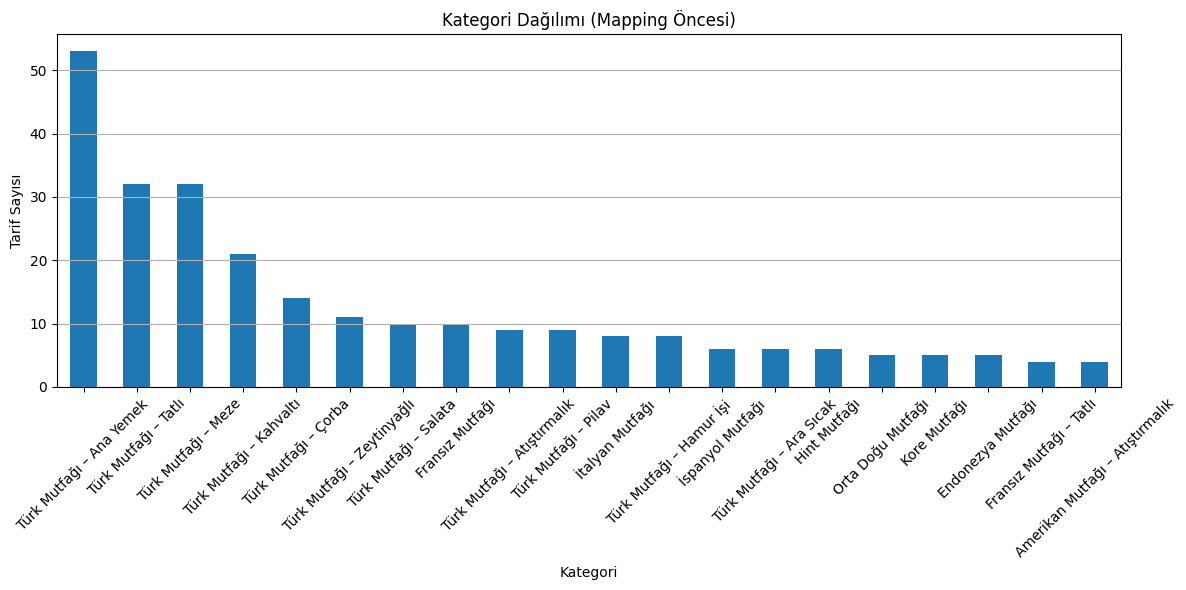

In [5]:
category_counts_before = df["foodcategory"].value_counts()

plt.figure(figsize=(12, 6))
category_counts_before.head(20).plot(kind='bar')
plt.title("Kategori Dağılımı (Mapping Öncesi)")
plt.xlabel("Kategori")
plt.ylabel("Tarif Sayısı")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**5. Kategori Mapping İşlemi**

In [6]:

kategori_map = {
    "Ana Yemek": "Ana Yemek", "Kebap": "Ana Yemek", "Mantı": "Ana Yemek", "Pide": "Ana Yemek", 
    "Ara Sıcak": "Ara Sıcak", "Döner": "Ana Yemek", "Lahmacun": "Ana Yemek", "Deniz Ürünü": "Ana Yemek",
    "Tatlı": "Tatlı", "Meze": "Meze", "Sos": "Meze", "Turşu": "Meze", "Çorba": "Çorba",
    "Kahvaltı": "Kahvaltı", "Gözleme": "Kahvaltı", "Ekmek": "Kahvaltı",
    "Atıstırmalık": "Atıstırmalık", "Sokak Lezzeti": "Atıstırmalık", "Hamur İşi": "Hamur İşi",
    "Börek": "Hamur İşi", "Salata": "Salata", "Zeytinyağlı": "Zeytinyağlı", "Makarna": "Ana Yemek",
    "Pilav": "Yan Yemek", "Garnitür": "Meze",  "İçecek": "İçecek",
    "Vejetaryen": "Ana Yemek", "Başlangıç": "Ara Sıcak", "Fermente": "Meze", 
    "Çiğ Köfte": "Meze", "Dolma": "Ara Sıcak", "Sebze Yemeği": "Ana Yemek"
}

def extract_category(raw_cat):
    if pd.isna(raw_cat): return []
    parts = re.split(r"–|-|—", raw_cat)
    return [parts[-1].strip()] if len(parts) >= 2 else [raw_cat.strip()]

def extract_and_map_category(raw_cat):
    extracted = extract_category(raw_cat)
    kategoriler = [kategori_map.get(k.strip(), None) for k in extracted]
    result = []
    for k in kategoriler:
        if isinstance(k, list): result.extend(k)
        elif k: result.append(k)
    return list(set(result))

df["etiketler"] = df["foodcategory"].apply(extract_and_map_category)


**6. Mapping Sonrası Kategori Dağılımı**

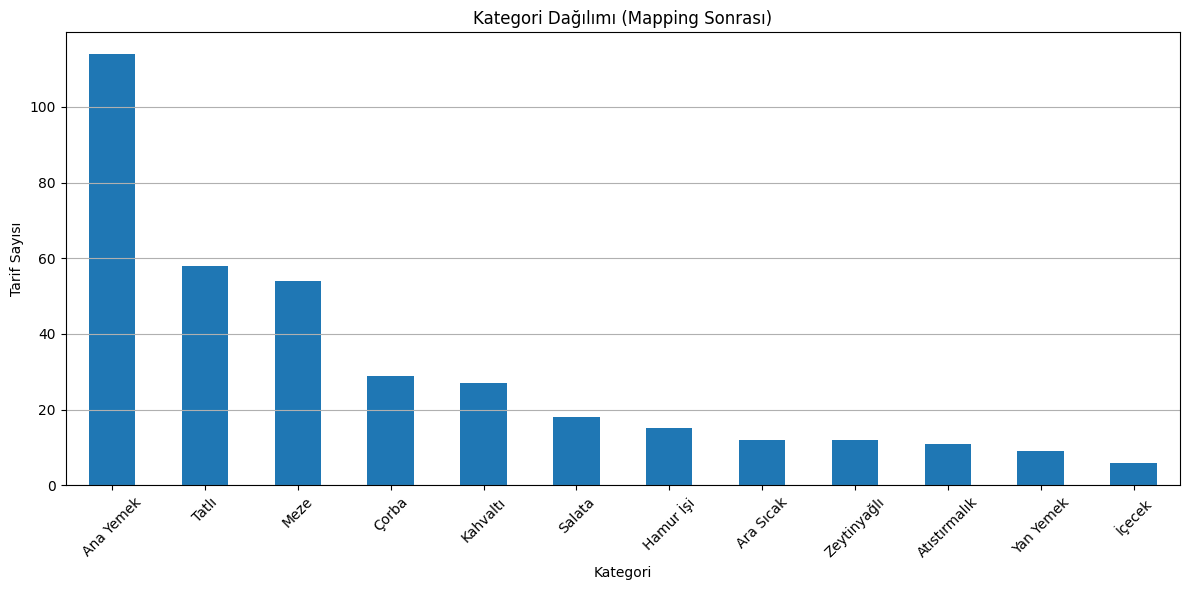

In [7]:

flat_kategoriler = [k for sublist in df["etiketler"] for k in sublist]
category_counts_after = Counter(flat_kategoriler)

plt.figure(figsize=(12, 6))
pd.Series(category_counts_after).sort_values(ascending=False).plot(kind='bar')
plt.title("Kategori Dağılımı (Mapping Sonrası)")
plt.xlabel("Kategori")
plt.ylabel("Tarif Sayısı")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**7. TF-IDF Vektörleştirme**

In [8]:

mlb = MultiLabelBinarizer()
etiket_encoded = mlb.fit_transform(df["etiketler"])
df = pd.concat([df, pd.DataFrame(etiket_encoded, columns=mlb.classes_)], axis=1)

X_raw = df["materials"].fillna("")
y = df[mlb.classes_].values
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X_raw)


**8. Veri Dengesizliği İçin Oversampling**

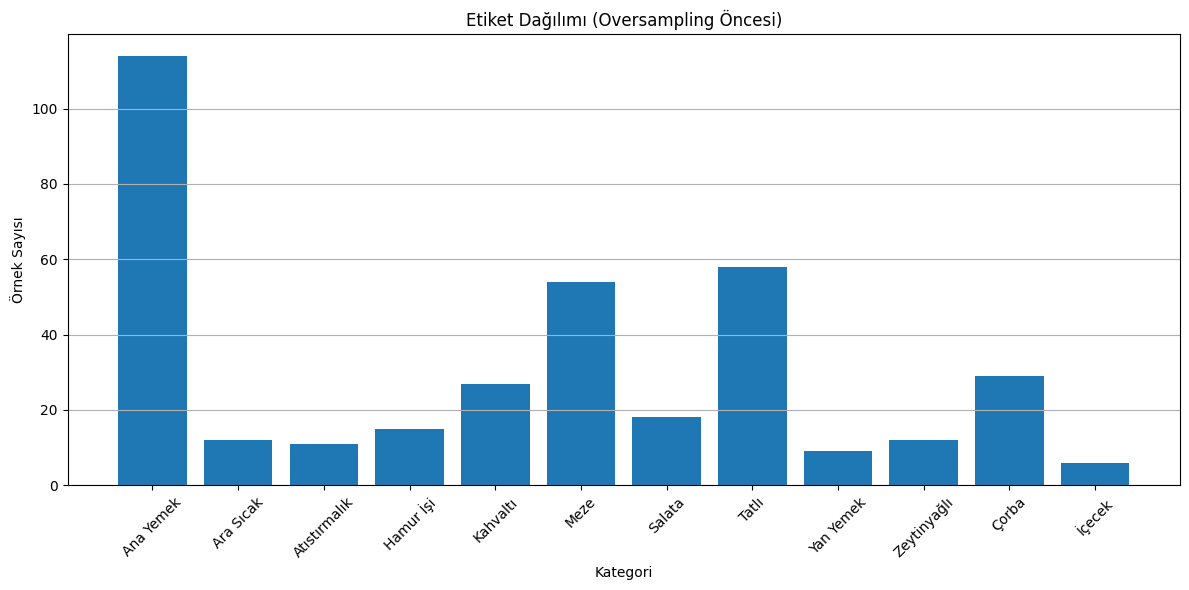

In [9]:
label_counts_before = np.sum(y, axis=0)
etiket_isimleri = mlb.classes_

plt.figure(figsize=(12, 6))
plt.bar(etiket_isimleri, label_counts_before)
plt.title("Etiket Dağılımı (Oversampling Öncesi)")
plt.xlabel("Kategori")
plt.ylabel("Örnek Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [10]:

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)


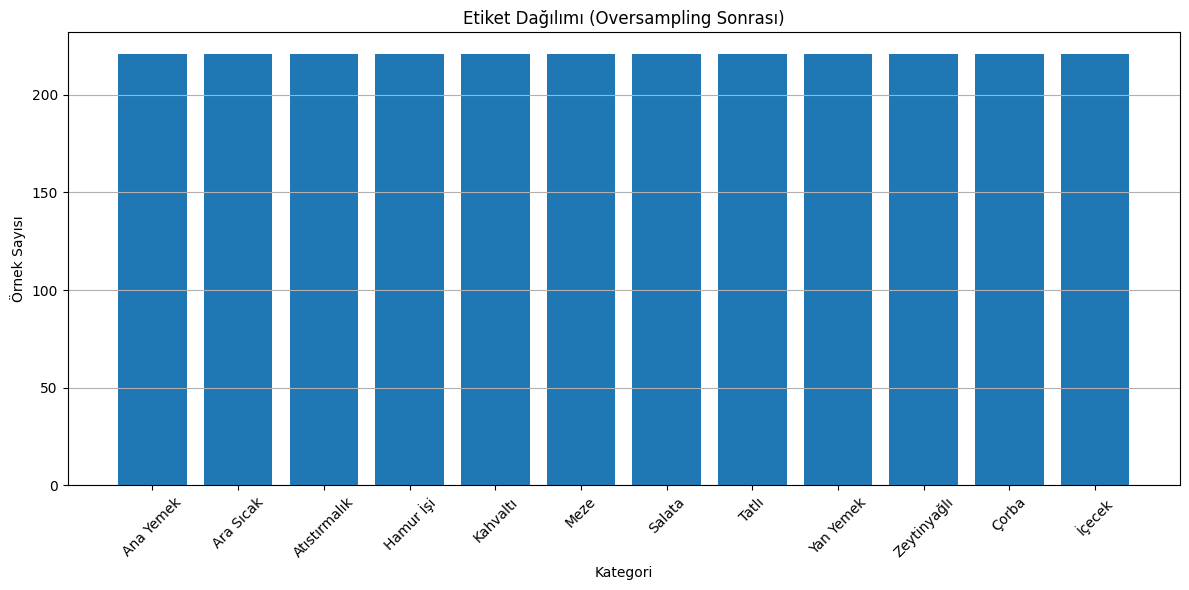

In [11]:
# Etiket dağılımı (sonra)
label_counts_after = np.sum(y_ros, axis=0)

plt.figure(figsize=(12, 6))
plt.bar(etiket_isimleri, label_counts_after)
plt.title("Etiket Dağılımı (Oversampling Sonrası)")
plt.xlabel("Kategori")
plt.ylabel("Örnek Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Model Eğitimi (Makine Öğrenmesi ve Derin Öğrenme)

**9. Naive Bayes Modeli ve F1-Skor Grafiği**

In [12]:

nb_model = OneVsRestClassifier(MultinomialNB())
nb_model.fit(X_train_ros, y_train_ros)
y_pred_nb = nb_model.predict(X_test_ros)
print("🔍 Naive Bayes Sonuçları:")
print(classification_report(y_test_ros, y_pred_nb, target_names=mlb.classes_))


🔍 Naive Bayes Sonuçları:
              precision    recall  f1-score   support

   Ana Yemek       0.91      0.24      0.38        41
   Ara Sıcak       0.98      0.93      0.95        43
Atıstırmalık       0.92      0.57      0.71        42
   Hamur İşi       0.88      0.49      0.63        47
    Kahvaltı       0.64      0.15      0.24        48
        Meze       0.86      0.28      0.42        43
      Salata       0.96      0.60      0.74        42
       Tatlı       0.88      0.73      0.80        49
   Yan Yemek       0.91      0.66      0.76        44
 Zeytinyağlı       0.90      0.88      0.89        40
       Çorba       0.92      0.61      0.73        56
      İçecek       1.00      0.83      0.91        36

   micro avg       0.91      0.57      0.71       531
   macro avg       0.90      0.58      0.68       531
weighted avg       0.89      0.57      0.67       531
 samples avg       0.56      0.57      0.57       531



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


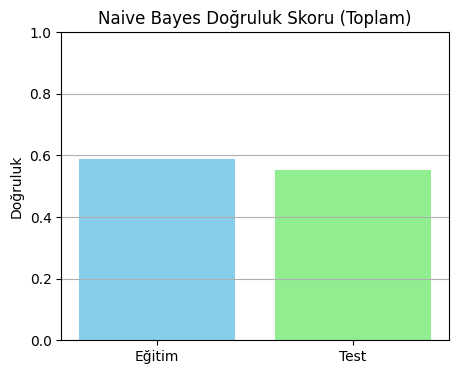

In [13]:
from sklearn.metrics import accuracy_score

# Eğitim ve test doğruluğu
train_acc = accuracy_score(y_train_ros, nb_model.predict(X_train_ros))
test_acc = accuracy_score(y_test_ros, y_pred_nb)

# Grafik
plt.figure(figsize=(5,4))
plt.bar(["Eğitim", "Test"], [train_acc, test_acc], color=["skyblue", "lightgreen"])
plt.ylim(0, 1)
plt.title("Naive Bayes Doğruluk Skoru (Toplam)")
plt.ylabel("Doğruluk")
plt.grid(axis='y')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


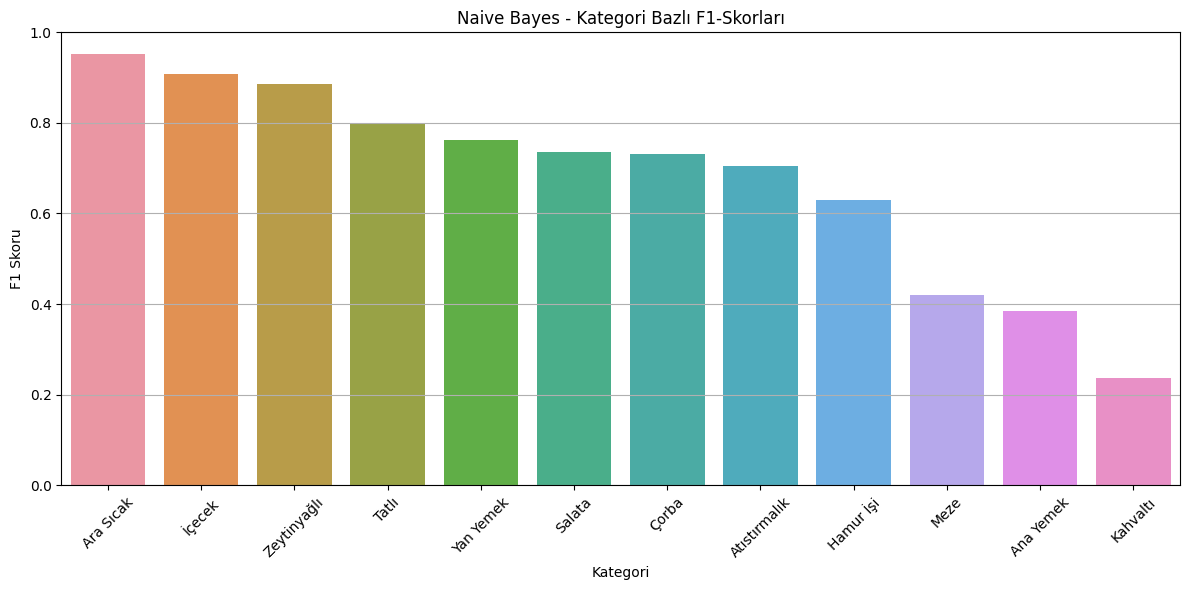

In [14]:
import seaborn as sns
report_dict = classification_report(y_test_ros, y_pred_nb, target_names=mlb.classes_, output_dict=True)
f1_scores = {label: metrics["f1-score"] for label, metrics in report_dict.items() if label in mlb.classes_}
f1_df = pd.DataFrame.from_dict(f1_scores, orient='index', columns=['F1-score']).sort_values("F1-score", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=f1_df.index, y="F1-score", data=f1_df)
plt.title("Naive Bayes - Kategori Bazlı F1-Skorları")
plt.xlabel("Kategori")
plt.ylabel("F1 Skoru")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [15]:
import time

# Eğitim süresi
start_train = time.time()
nb_model.fit(X_train_ros, y_train_ros)
end_train = time.time()

# Tahmin süresi
start_pred = time.time()
y_pred_nb = nb_model.predict(X_test_ros)
end_pred = time.time()

train_time = end_train - start_train
predict_time = end_pred - start_pred


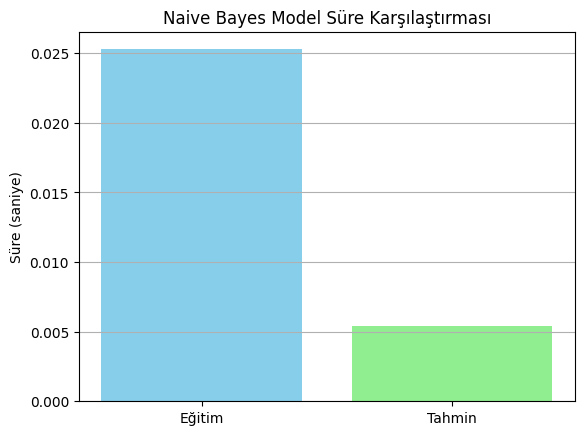

In [16]:
plt.bar(["Eğitim", "Tahmin"], [train_time, predict_time], color=["skyblue", "lightgreen"])
plt.ylabel("Süre (saniye)")
plt.title("Naive Bayes Model Süre Karşılaştırması")
plt.grid(axis='y')
plt.show()


In [17]:
import sys
print(f"TF-IDF matrisi bellekte: {sys.getsizeof(X)} byte")
print(f"Model nesnesi bellekte: {sys.getsizeof(nb_model)} byte")


TF-IDF matrisi bellekte: 56 byte
Model nesnesi bellekte: 56 byte


**10. MLP Modeli ile Eğitim**

In [18]:
#MLP
model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(y.shape[1], activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history_ros = model.fit(
    X_train_ros.toarray(), y_train_ros,
    validation_data=(X_test_ros.toarray(), y_test_ros),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-06 06:12:07.040016: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0896 - loss: 0.7531 - val_accuracy: 0.2900 - val_loss: 0.3384
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2268 - loss: 0.3290 - val_accuracy: 0.5782 - val_loss: 0.2751
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4732 - loss: 0.2746 - val_accuracy: 0.6667 - val_loss: 0.2450
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5767 - loss: 0.2519 - val_accuracy: 0.7363 - val_loss: 0.2289
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6525 - loss: 0.2385 - val_accuracy: 0.7213 - val_loss: 0.2209
Epoch 6/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6886 - loss: 0.2274 - val_accuracy: 0.8154 - val_loss: 0.2101
Epoch 7/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7065 - loss: 0.2184 - val_accuracy: 0.7476 - val_loss: 0.2048
Epoch 8/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7216 - loss: 0.2130 - val_accuracy: 0.

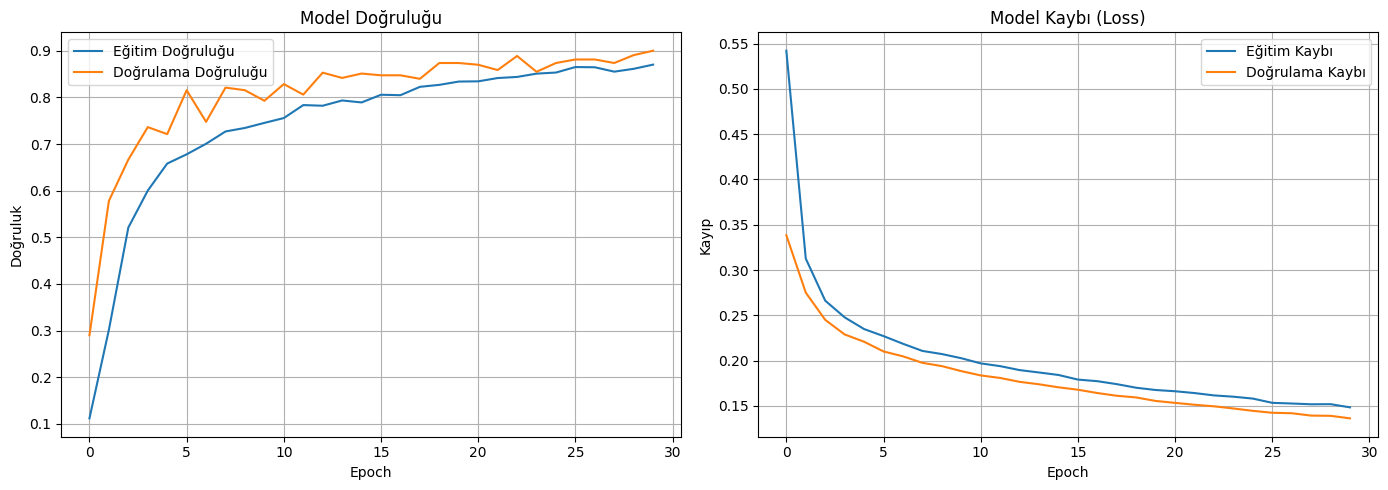

In [19]:
import matplotlib.pyplot as plt

# Eğitim & Doğrulama Doğruluk ve Kayıp Grafikleri
plt.figure(figsize=(14, 5))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history_ros.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history_ros.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history_ros.history['loss'], label='Eğitim Kaybı')
plt.plot(history_ros.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**11. RNN ve 1D-CNN İçin Veri Hazırlığı ve Tokenleştirme**

In [20]:
# ────────────────────────────────────────────────────────────────
# HÜCRE: RNN ve 1D-CNN MODELLERİ EKLE, EĞİT, TEST ET, KARŞILAŞTIR
# ────────────────────────────────────────────────────────────────

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.metrics import BinaryAccuracy

# 1) SEQUENCE VERİSİNİ HAZIRLA
max_words    = 5000    # sözlük boyutu
max_len      = 100     # sequence uzunluğu (padding)
tokenizer    = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_raw)  # X_raw: materials sütunu (string)

# tüm tarifleri sequence'e çevir, pad et
seqs  = tokenizer.texts_to_sequences(X_raw)
X_seq = pad_sequences(seqs, maxlen=max_len)

# oversampling aynen TF-IDF ile olduğu gibi
X_ros_seq, y_ros_seq = RandomOverSampler(random_state=42).fit_resample(X_seq, y)
# train/test ayrımı
X_tr_seq, X_te_seq, y_tr_seq, y_te_seq = train_test_split(
    X_ros_seq, y_ros_seq, test_size=0.2, random_state=42
)

# ortak callback
early = EarlyStopping(patience=5, restore_best_weights=True)

**12. Model-2: RNN (Recurrent Neural Network) Eğitimi ve Değerlendirmesi**

In [21]:
# ---------------------------------------------------------------
# MODEL-2: Basit RNN
# ---------------------------------------------------------------
model2 = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    SimpleRNN(64),
    Dropout(0.5),
    Dense(y.shape[1], activation='sigmoid')
])
model2.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy')]
)
print("🔄 Model-2 (RNN) eğitimi başladı...")
hist2 = model2.fit(
    X_tr_seq, y_tr_seq,
    validation_data=(X_te_seq, y_te_seq),
    epochs=30, batch_size=16,
    callbacks=[early],
    verbose=1
)
# test doğruluğu
loss2, acc2 = model2.evaluate(X_te_seq, y_te_seq, verbose=0)
print(f"✅ Model-2 (RNN) test doğruluğu: {acc2:.4f}")

🔄 Model-2 (RNN) eğitimi başladı...
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8220 - loss: 0.4335 - val_accuracy: 0.9167 - val_loss: 0.2506
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9210 - loss: 0.2506 - val_accuracy: 0.9426 - val_loss: 0.1721
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9448 - loss: 0.1732 - val_accuracy: 0.9620 - val_loss: 0.1206
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9628 - loss: 0.1286 - val_accuracy: 0.9783 - val_loss: 0.0911
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9699 - loss: 0.1058 - val_accuracy: 0.9821 - val_loss: 0.0690
Epoch 6/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9766 - loss: 0.0828 - val_accuracy: 0.9845 - val_loss: 0.0560
Epoch 7/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9800 - loss: 0.0721 - val_accuracy: 0.9871 - val_loss: 0.0477
Epoch 8/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9835 - loss: 0.0627 - val_accuracy: 0.990

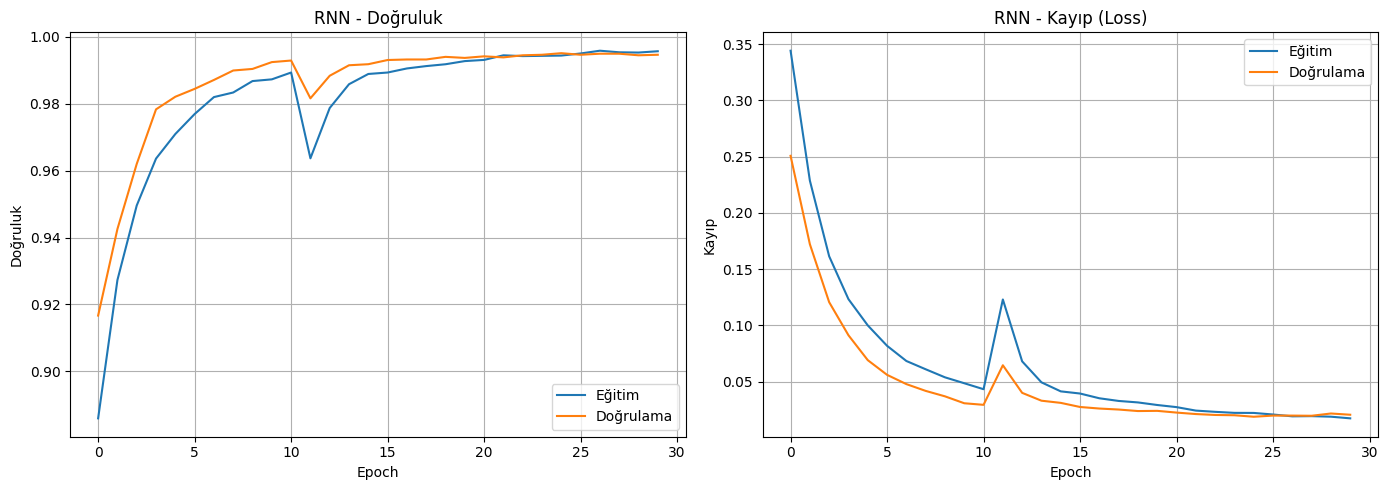

In [22]:

plt.figure(figsize=(14, 5))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(hist2.history['accuracy'], label='Eğitim')
plt.plot(hist2.history['val_accuracy'], label='Doğrulama')
plt.title('RNN - Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(hist2.history['loss'], label='Eğitim')
plt.plot(hist2.history['val_loss'], label='Doğrulama')
plt.title('RNN - Kayıp (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**13. Model-3: 1D-CNN (Bir Boyutlu Evrişimsel Sinir Ağı) Eğitimi ve Değerlendirmesi**

In [23]:
model3 = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(y.shape[1], activation='sigmoid')
])
model3.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy')]
)
print("\n🔄 Model-3 (1D-CNN) eğitimi başladı...")
hist3 = model3.fit(
    X_tr_seq, y_tr_seq,
    validation_data=(X_te_seq, y_te_seq),
    epochs=30, batch_size=16,
    callbacks=[early],
    verbose=1
)
# test doğruluğu
loss3, acc3 = model3.evaluate(X_te_seq, y_te_seq, verbose=0)
print(f"✅ Model-3 (1D-CNN) test doğruluğu: {acc3:.4f}")


🔄 Model-3 (1D-CNN) eğitimi başladı...
Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8567 - loss: 0.4176 - val_accuracy: 0.9167 - val_loss: 0.2307
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9282 - loss: 0.2113 - val_accuracy: 0.9659 - val_loss: 0.0971
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9641 - loss: 0.1065 - val_accuracy: 0.9832 - val_loss: 0.0523
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9791 - loss: 0.0678 - val_accuracy: 0.9873 - val_loss: 0.0355
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9880 - loss: 0.0419 - val_accuracy: 0.9928 - val_loss: 0.0266
✅ Model-3 (1D-CNN) test doğruluğu: 0.9167


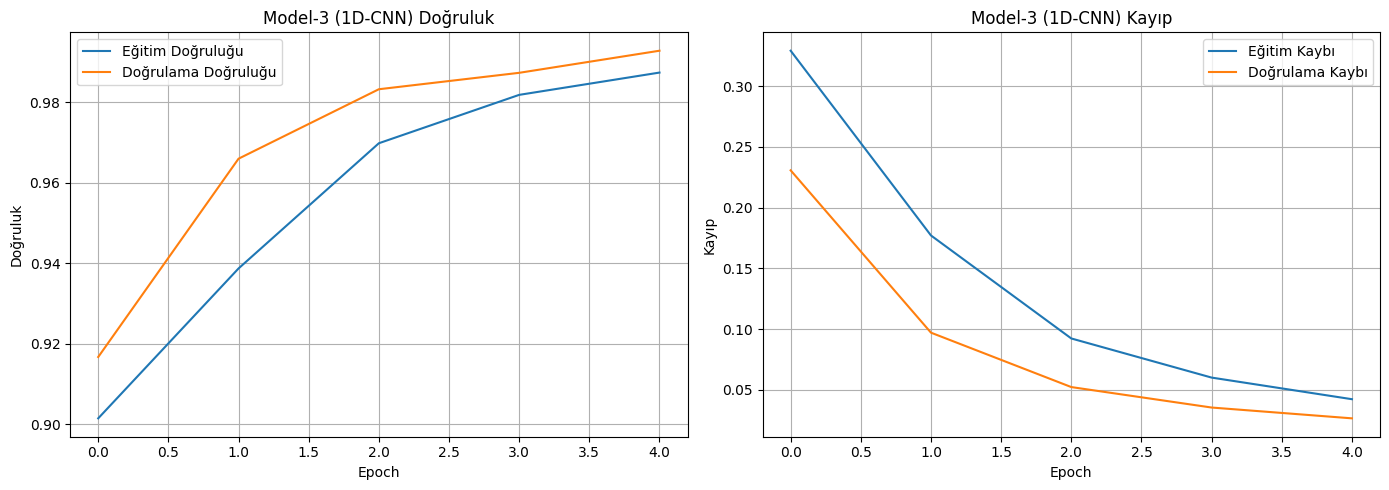

In [24]:
plt.figure(figsize=(14, 5))

# Doğruluk
plt.subplot(1, 2, 1)
plt.plot(hist3.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(hist3.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model-3 (1D-CNN) Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Kayıp
plt.subplot(1, 2, 2)
plt.plot(hist3.history['loss'], label='Eğitim Kaybı')
plt.plot(hist3.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model-3 (1D-CNN) Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Model Performans Analizi ve Karşılaştırma

**14. Modellerin Karşılaştırılması**

In [25]:
# MODEL-1 (MLP) TEST DOĞRULUĞU
# ---------------------------------------------------------------
loss1, acc1 = model.evaluate(X_test_ros.toarray(), y_test_ros, verbose=0)
print(f"\n📊 Model-1 (MLP) test doğruluğu: {acc1:.4f}")

# ---------------------------------------------------------------
# SON KARŞILAŞTIRMA
# ---------------------------------------------------------------
print("\n=== MODELLERİN KARŞILAŞTIRMASI ===")
print(f"• MLP       : {acc1:.4f}")
print(f"• RNN       : {acc2:.4f}")
print(f"• 1D-CNN    : {acc3:.4f}")
print(f"• 1D-CNN    : {acc3:.4f}")


📊 Model-1 (MLP) test doğruluğu: 0.9002

=== MODELLERİN KARŞILAŞTIRMASI ===
• MLP       : 0.9002
• RNN       : 0.9951
• 1D-CNN    : 0.9167
• 1D-CNN    : 0.9167


/tmp/ipykernel_13/1343163596.py:31: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


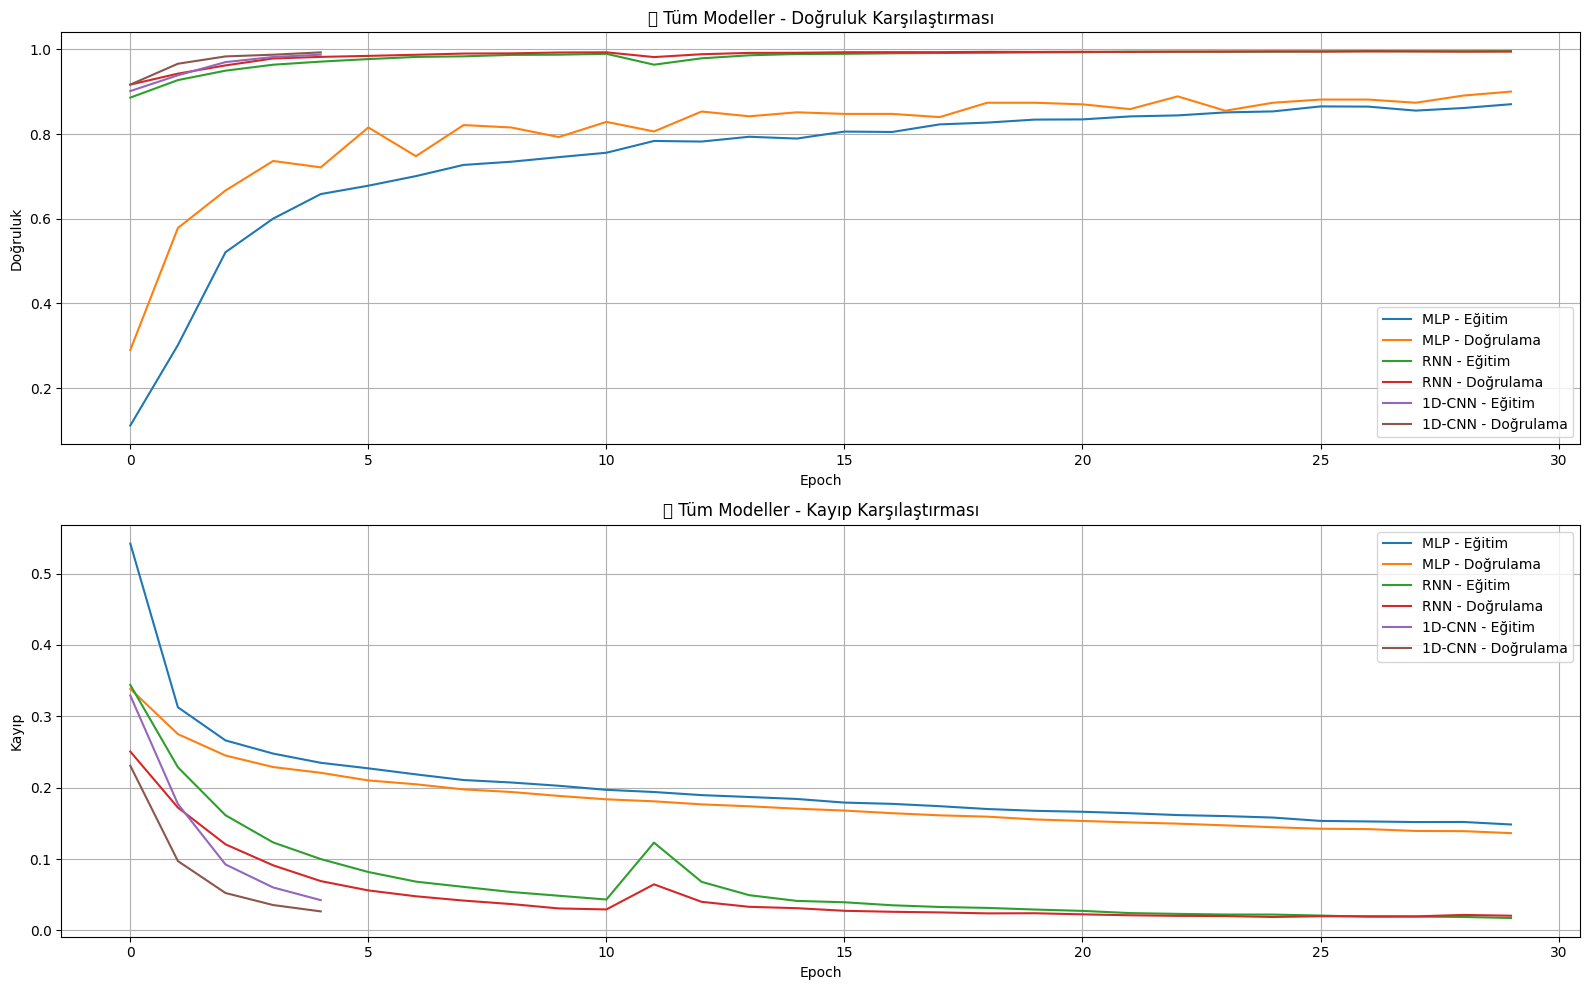

In [26]:
plt.figure(figsize=(16, 10))

# ───────────── DOĞRULUK GRAFİĞİ ─────────────
plt.subplot(2, 1, 1)
plt.plot(history_ros.history['accuracy'], label='MLP - Eğitim')
plt.plot(history_ros.history['val_accuracy'], label='MLP - Doğrulama')
plt.plot(hist2.history['accuracy'], label='RNN - Eğitim')
plt.plot(hist2.history['val_accuracy'], label='RNN - Doğrulama')
plt.plot(hist3.history['accuracy'], label='1D-CNN - Eğitim')
plt.plot(hist3.history['val_accuracy'], label='1D-CNN - Doğrulama')
plt.title("🔍 Tüm Modeller - Doğruluk Karşılaştırması")
plt.ylabel("Doğruluk")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

# ───────────── KAYIP GRAFİĞİ ─────────────
plt.subplot(2, 1, 2)
plt.plot(history_ros.history['loss'], label='MLP - Eğitim')
plt.plot(history_ros.history['val_loss'], label='MLP - Doğrulama')
plt.plot(hist2.history['loss'], label='RNN - Eğitim')
plt.plot(hist2.history['val_loss'], label='RNN - Doğrulama')
plt.plot(hist3.history['loss'], label='1D-CNN - Eğitim')
plt.plot(hist3.history['val_loss'], label='1D-CNN - Doğrulama')
plt.title("🔍 Tüm Modeller - Kayıp Karşılaştırması")
plt.ylabel("Kayıp")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


/tmp/ipykernel_13/3906299552.py:32: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/3906299552.py:32: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


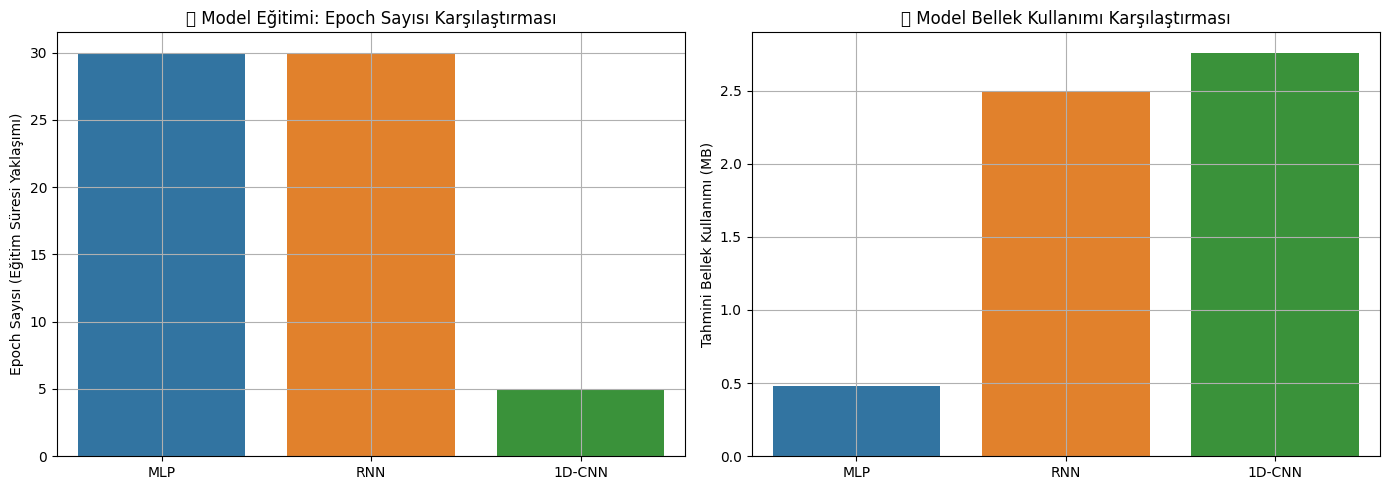

In [27]:
# Eğitim süresi karşılaştırması: Epoch sayıları üzerinden
mlp_epochs = len(history_ros.history['loss'])
rnn_epochs = len(hist2.history['loss'])
cnn_epochs = len(hist3.history['loss'])

# Model parametre sayıları (kabaca belleği yansıtır)
mlp_params = model.count_params()
rnn_params = model2.count_params()
cnn_params = model3.count_params()

# Her 1 milyon parametre ~4 MB bellek kullanır varsayımıyla (float32)
def param_to_mb(p): return round(p * 4 / (1024**2), 2)

# Karşılaştırma tablosu
compare_df = pd.DataFrame({
    "Epoch Sayısı (Eğitim Süresi Yaklaşımı)": [mlp_epochs, rnn_epochs, cnn_epochs],
    "Parametre Sayısı": [mlp_params, rnn_params, cnn_params],
    "Tahmini Bellek Kullanımı (MB)": [param_to_mb(mlp_params), param_to_mb(rnn_params), param_to_mb(cnn_params)]
}, index=["MLP", "RNN", "1D-CNN"])

# Görselleştirme
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=compare_df.index, y="Epoch Sayısı (Eğitim Süresi Yaklaşımı)", data=compare_df, ax=axs[0])
axs[0].set_title("⏱️ Model Eğitimi: Epoch Sayısı Karşılaştırması")
axs[0].grid(True)

sns.barplot(x=compare_df.index, y="Tahmini Bellek Kullanımı (MB)", data=compare_df, ax=axs[1])
axs[1].set_title("💾 Model Bellek Kullanımı Karşılaştırması")
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Chatbot Mantığı ve Uygulaması

**15. Veri Setinden Malzeme Kümesi Çıkarma**

In [28]:
# Veri setindeki tüm malzemeleri temizleyip listeye al
tum_malzemeler = set()
for satir in df["materials"].dropna():
    for m in satir.lower().split(","):
        tum_malzemeler.add(m.strip())


In [29]:
!pip install -q nltk scikit-learn pandas
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
df['materials'] = df['materials'].astype(str).str.lower()

**16. Doğal Dil İşleme Malzeme Filtreleme**

In [31]:
def extract_ingredients(user_input):
    tokens = word_tokenize(user_input.lower())
    stop_words = ['biraz', 'sadece', 've', 'var', 'tek', 'yalnızca']
    return [t for t in tokens if t.isalpha() and t not in stop_words]


**17. Kullanıcının Malzemelerine Göre Tarif Eşleştirme**

In [32]:
def match_recipes(user_ingredients):
    suggestions = []

    for _, row in df.iterrows():
        tarif_malzeme = re.findall(r'\w+', row['malzemeler'])
        tarif_malzeme = list(set([x.strip().lower() for x in tarif_malzeme]))

        common = set(user_ingredients) & set(tarif_malzeme)
        missing = set(tarif_malzeme) - set(user_ingredients)
        
        if len(common) >= 1:
            suggestions.append({
                'yemek': row['yemek_adi'],
                'eşleşen_malzeme_sayısı': len(common),
                'eksik_malzeme': len(missing),
                'eksikler': list(missing),
                'tam_malzeme_listesi': tarif_malzeme
            })
    
    return sorted(suggestions, key=lambda x: x['eksik_malzeme'])


**18. Cümleden Kategori İpuçları Çıkarımı**

In [33]:
# Otomatik kategori anahtarları çıkar
kategori_anahtarları = set()
for liste in df["etiketler"]:
    kategori_anahtarları.update([etik.lower() for etik in liste])

def kategori_ipuclari_bul(girdi):
    temiz = re.sub(r"[^\w\s]", "", girdi.lower())
    return [k.title() for k in kategori_anahtarları if k in temiz]


**19. Chatbot Oluşturma**

In [34]:
import re

# 1. Dinamik malzeme kümesi oluştur (veri seti yüklendikten sonra çalıştırılmalı!)
malzeme_kumesi = set()
for m in df["materials"].dropna():
    temiz = re.sub(r"[^\w\s]", "", m.lower())
    malzeme_kumesi.update(temiz.split())

tum_malzemeler = sorted(list(malzeme_kumesi))

def yemek_adi_ara(girdi):
    girdi_lower = girdi.lower()
    for _, row in df.iterrows():
        if girdi_lower in row["foodname"].lower():
            return f"""
📌 Tarif Adına Göre Eşleşme Bulundu!
📌 Tarif: {row["foodname"]}
🧾 Malzemeler: {row["materials"]}
🕐 Süre: {row["toplam_sure_dk"]} dk | 🍽️ Porsiyon: {row["porsiyon_sayisi"]}
👨‍🍳 Açıklama:
{row["description"]}
"""
    return None


# 2. Malzeme temizleyici (dilersen kullanabilirsin)
def malzeme_temizle(girdi):
    temiz = re.sub(r"[^\w\s]", "", girdi.lower())
    return [m for m in tum_malzemeler if m in temiz]

# 3. Kullanıcıdan malzeme ve kategori çıkarımı
def parse_user_input(user_input):
    user_input = user_input.lower()
    malzemeler = []
    kategori_ipuclari = []
    malzeme_kisitli = False

    bilinen_malzemeler = tum_malzemeler  # Artık dinamik

    kategori_anahtarları = [
        "tatlı", "çorba", "salata", "kahvaltı", "meze", "hamur işi",
        "ana yemek", "atıştırmalık", "ara sıcak"
    ]
    kategori_kelime_haritasi = {
        "kurabiye": "Tatlı",
        "kek": "Tatlı",
        "pasta": "Tatlı",
        "çorba": "Çorba",
        "pilav": "Yan Yemek",
        "salata": "Salata"
    }

    for malzeme in bilinen_malzemeler:
        if malzeme in user_input:
            malzemeler.append(malzeme)

    for kelime, kategori in kategori_kelime_haritasi.items():
        if kelime in user_input and kategori not in kategori_ipuclari:
            kategori_ipuclari.append(kategori)

    for k in kategori_anahtarları:
        if k in user_input and k.title() not in kategori_ipuclari:
            kategori_ipuclari.append(k.title())

    sinirli_ifadeler = ["sadece", "tek", "başka yok", "malzeme yok", "malzemem yok", "dışında yok", "yalnızca"]
    if any(ifade in user_input for ifade in sinirli_ifadeler):
        if len(malzemeler) <= 1:
            malzeme_kisitli = True

    return malzemeler, kategori_ipuclari, malzeme_kisitli

# 4. MLP tahminci
def predict_categories_from_materials(materials_list):
    if not materials_list:
        return []

    metin = ", ".join(materials_list)
    X_input = tfidf.transform([metin])
    preds = model.predict(X_input.toarray())[0]

    if max(preds) < 0.15:
        print("⚠️ MLP kararsız kaldı, tahmin yapılmayacak.")
        return []

    skorlar = {mlb.classes_[i]: round(p, 3) for i, p in enumerate(preds)}
    print("🔬 MLP Tahmin Skorları:")
    for k, v in sorted(skorlar.items(), key=lambda x: -x[1]):
        print(f"  {k}: {v}")

    tahmin_edilen = [k for k, p in skorlar.items() if p >= 0.1]
    return tahmin_edilen

# 5. Tarif önerici
def öner_tarif(tahmin_kategorileri, kategori_ipuclari, malzeme_listesi, malzeme_kisitli=False):
    filtreli_df = df.copy()

    ortak_kategoriler = list(set(tahmin_kategorileri) & set(kategori_ipuclari))
    if ortak_kategoriler:
        print(f"✅ Tahmin + Cümle kategorisi uyuştu: {ortak_kategoriler}")
        tum_kategoriler = ortak_kategoriler
    else:
        tum_kategoriler = list(set(tahmin_kategorileri + kategori_ipuclari))

    uygun_tarifler = []

    for _, row in filtreli_df.iterrows():
        tarif_malzeme = row["materials"].lower() if pd.notna(row["materials"]) else ""
        tarif_malzeme = re.sub(r"[^\w\s]", "", tarif_malzeme)
        tarif_malzeme_listesi = tarif_malzeme.split()

        if malzeme_kisitli:
            fark = set(tarif_malzeme_listesi) - set(malzeme_listesi)
            if fark:
                continue  # yalnızca istenen malzemeyi içermeyen tarifler elenir

        eslesen = set(malzeme_listesi) & set(tarif_malzeme_listesi)
        eksik = set(malzeme_listesi) - set(tarif_malzeme_listesi)

        if not eslesen:
            continue

        kategori_puan = 1 if any(k in row["etiketler"] for k in tum_kategoriler) else 0

        uygun_tarifler.append({
            "yemek": row["foodname"],
            "malzeme": row["materials"],
            "sure": row["toplam_sure_dk"],
            "porsiyon": row["porsiyon_sayisi"],
            "aciklama": row["description"],
            "eslesen_sayisi": len(eslesen),
            "eksik_sayisi": len(eksik),
            "eksikler": list(eksik),
            "puan": kategori_puan
        })

    if not uygun_tarifler:
        return f"❌ Uygun tarif bulunamadı.\n🔎 Malzeme: {malzeme_listesi}\n📂 Kategori: {tum_kategoriler}"

    uygun_tarifler = sorted(uygun_tarifler, key=lambda x: (x["eksik_sayisi"], -x["puan"], -x["eslesen_sayisi"]))
    secilen = uygun_tarifler[0]

    if secilen["eksik_sayisi"] >= 3:
        return f"❌ Bu malzemelerle tarif öneremem. En az 3 malzeme eksik görünüyor."

    elif 1 <= secilen["eksik_sayisi"] <= 2:
        return f"""
⚠️ Bu tarif için eksik malzeme olabilir!
Yine de deneyebilirsin:

📌 Tarif: {secilen["yemek"]}
🧾 Malzemeler: {secilen["malzeme"]}
🕐 Süre: {secilen["sure"]} dk | 🍽️ Porsiyon: {secilen["porsiyon"]}
👨‍🍳 Açıklama:
{secilen["aciklama"]}
"""

    else:
        return f"""
✅ Verdiğin malzemeleri içeren bir tarif buldum! İşte önerim:

📌 Tarif: {secilen["yemek"]}
🧾 Malzemeler: {secilen["malzeme"]}
🕐 Süre: {secilen["sure"]} dk | 🍽️ Porsiyon: {secilen["porsiyon"]}
👨‍🍳 Açıklama:
{secilen["aciklama"]}
"""


# 6. Chatbot başlatıcı
def basla_chatbot():
    print("🍽️ TarifBot'a hoş geldin! Ne yapmak istediğini yaz (örnek: elma tarçınlı tatlı):")
    while True:
        user_input = input("👤 Sen: ")
        if user_input.lower() in ["çık", "exit", "bitir"]:
            print("👋 Görüşmek üzere!")
            break

        yanit_ismi = yemek_adi_ara(user_input)
        if yanit_ismi:
            print(yanit_ismi)
            continue  # diğer işlemleri yapmadan döngünün başına dön


        malzemeler, kategori_ipuclari, malzeme_kisitli = parse_user_input(user_input)
        tahminler = predict_categories_from_materials(malzemeler)

        print(f"\n🔍 Elde edilen malzemeler: {malzemeler}")
        print(f"📂 Tahmin edilen kategoriler: {tahminler}")
        print(f"🧠 Cümleden anlaşılan kategori ipuçları: {kategori_ipuclari}")

        if malzeme_kisitli:
            print("⚠️ Uyarı: Elinizde sadece 1 malzeme var. Tarifler sınırlı olabilir.")

        yanit = öner_tarif(tahminler, kategori_ipuclari, malzemeler, malzeme_kisitli)

        print(yanit)


**20. Chatbot Başlatma**

In [35]:
#basla_chatbot()